<h1> 2024 1학기 기계학습 심화 팀 프로젝트 </h1>
<h2>Pidray dataset을 이용한 Image Classification Using VGGNET</h2>

<h3>B911166 전민</h3>
<p>
<div>train data로는 29457장의 이미지를 사용하여 학습하였고 test data로는 9482장의 이미지를 사용하였다.</div>
<div>test data로는 각각 Hard, Easy, Hidden image set이 존재했고 그 중 금지 품목이 한 개만 포함된 Easy set을 사용하여 모델 테스트를 진행하였다.</div>
<div>https://github.com/bywang2018/security-dataset/blob/main/README.md</div>
</p>


In [1]:
!nvidia-smi

Mon May 20 12:37:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:06:00.0  On |                  N/A |
|  0%   38C    P8             N/A /  115W |     555MiB /   8188MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<h3>1)이미지 학습 진행</h3>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import time
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


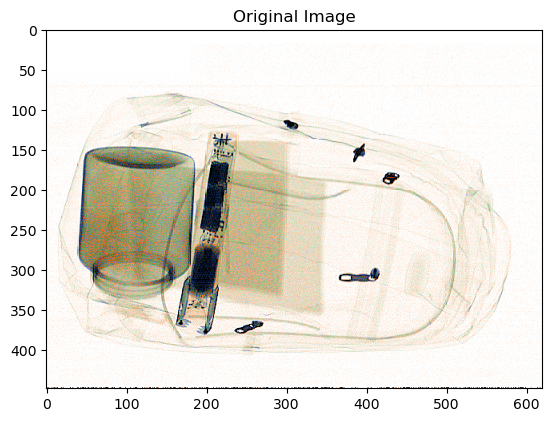

In [7]:
# Display original image
plt.imshow(img)
plt.title("Original Image")
plt.show()

In [8]:
all_pixels  = img.reshape((-1,3)).astype(float) # all_pixels : data
print(all_pixels.shape)

(277760, 3)


In [4]:
# # crop
# class CustomDataset(Dataset):
#     def __init__(self, img_dir, annotation_dir, transform=None):
#         self.img_dir = img_dir
#         self.annotation_dir = annotation_dir
#         self.transform = transform
#         self.img_names = os.listdir(img_dir)

#     def __len__(self):
#         return len(self.img_names)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_names[idx])
#         annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

#         image = Image.open(img_path).convert("RGB")
        
#         with open(annotation_path, 'r') as f:
#             bbox_data = f.readline().strip().split()
#             label = int(bbox_data[0])
#             bbox = [float(b) for b in bbox_data[1:]] # x_center, y_center, width, height

#         # 이미지 크기에 맞춰 실제 바운딩 박스의 좌표로 변환
#         x_center, y_center, width, height = bbox
#         x1 = int((x_center - width / 2) * image.width)
#         y1 = int((y_center - height / 2) * image.height)
#         x2 = int((x_center + width / 2) * image.width)
#         y2 = int((y_center + height / 2) * image.height)

#         # 이미지를 바운딩 박스에 맞춰서 crop
#         image = image.crop((x1, y1, x2, y2))
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label, torch.tensor(bbox)
# non-crop
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))

        image = Image.open(img_path).convert("RGB")
        
        with open(annotation_path, 'r') as f:
            bbox_data = f.readline().strip().split()
            label = int(bbox_data[0])
            bbox = torch.tensor([float(b) for b in bbox_data[1:]])
            
        if self.transform:
            image = self.transform(image)
        
        return image, label, bbox


In [5]:
root = './'

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 노말리이징: (원래 데이터 x - μ) / σ   μ=(0.5,0.5,0.5) σ = (0.5, 0.5, 0.5). 값이 세개인 이유는 RGB라서 채널이 세개이기 떄문
    transforms.Resize((224,224)) # 모든 이미지를 240 x 300의 사이즈로 리사이징
])

train_image_dir = root+'Pidray/train/images'
train_label_dir = root+'Pidray/train/labels'
test_image_dir = root+'Pidray/test/images'
test_label_dir = root+'Pidray/test/labels'

train_data = CustomDataset(train_image_dir, train_label_dir, transform=trans)
test_data = CustomDataset(test_image_dir, test_label_dir, transform=trans)

print('Training Data:', len(train_data), 'Test Data', len(test_data))


batch_size = 74
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)

Training Data: 29454 Test Data 9482


In [6]:
classes = ["Baton", "Pliers", "Hammer", "Powerbank", 
        "Scissors", "Wrench", "Gun", "Bullet", 
        "Sprayer", "Handcuffs", "Knife", "Lighter"]

In [7]:
import matplotlib.patches as patches

# 바운딩 박스를 그리는 함수
def draw_bbox(ax, bbox, label):
    # bbox = [x_center, y_center, width, height]
    # 이미지 크기에 따라 실제 바운딩 박스의 좌표로 변환
    x_center, y_center, width, height = bbox
    x1 = (x_center - width / 2) * 224   # 이미지 너비에 맞춰 조정
    y1 = (y_center - height / 2) * 224  # 이미지 높이에 맞춰 조정
    
    # 바운딩 박스 그리기
    rect = patches.Rectangle((x1, y1), width * 224, height * 224, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # 라벨 표시
    ax.text(x1, y1, label, color='white', backgroundcolor='red')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

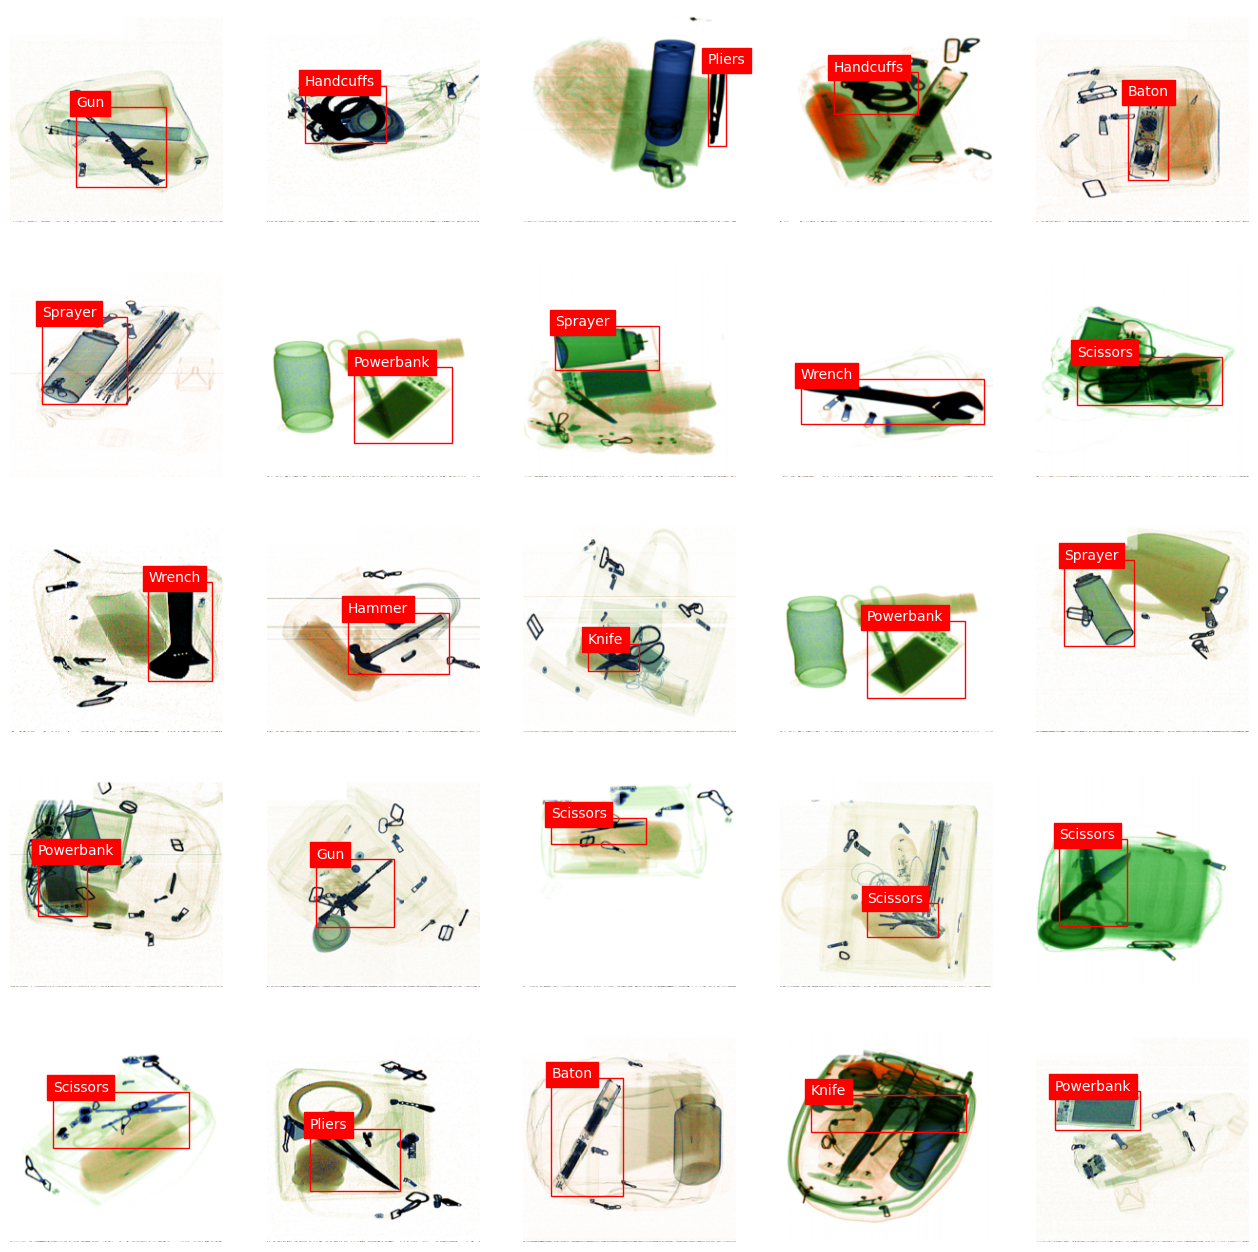

In [13]:
# 데이터 로더에서 첫 번째 배치만 가져오기
images, labels, bboxes = next(iter(train_loader))

# batch size: 64, kernel: 3(RGB), image size: 480 x 600
sample_index = np.random.choice(batch_size, size=25)     # 25개의 랜덤 샘플 인덱스 선택
num_samples = sample_index.size

random_samples = images[sample_index].cpu().numpy()

plt.figure(figsize=(16, 16))

# 테스트 샘플 표시
for k in range(num_samples):
    ax = plt.subplot(5, 5, k + 1)
    img = random_samples[k].reshape(3,224, 224).transpose(1,2,0)/2 + 0.5
    plt.imshow(img)
    label = classes[labels[sample_index[k]].item()]
    bbox = bboxes[sample_index[k]] # 해당 샘플의 바운딩 박스 정보
    draw_bbox(ax, bbox, label) # 바운딩 박스 그리기
    plt.axis('off')

plt.show() 

In [8]:
class MyVGGNet(nn.Module):
    def __init__(self):
        super(MyVGGNet, self).__init__()
        self.features = nn.Sequential(
            # 첫 번째 컨볼루션 블록
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 두 번째 컨볼루션 블록
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 세 번째 컨볼루션 블록
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 네 번째 컨볼루션 블록
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 다섯 번째 컨볼루션 블록
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # 가정한 입력 이미지 크기에 따라 조정 필요
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 12)  # 최종 출력 클래스 수는 12
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 피처 맵을 펼친다.
        x = self.classifier(x)
        return x


In [9]:
#model = MyVGGNet().to(device)
model = torch.load('./model/VGGNET16_19.pth').to(device)
print(model)

MyVGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [10]:
lr=1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [11]:
# training and test

# epoch: 10
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(19,95):
    epoch_start_time = time.time()  # 에폭 시작 시간 기록
    # training phase
    model.train()  # drop out layer가 있다면 drop out을 활성화. 지금은 없어서 상관 없음
    current_loss= 0.0
    for batch_num, (x, target, bbox) in enumerate(train_loader):
        start_time = time.time()  # 배치 처리 시작 시간 기록
        x, target = x.to(device), target.to(device)

        # forward propagation
        out = model(x)
        loss = criterion(out,target)

        # backward propagation
        optimizer.zero_grad()   # 미분값 리셋
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 50 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            batch_time = time.time() - start_time  # 배치 처리 시간 계산
            total_time = time.time() - epoch_start_time  # 총 경과 시간 계산
            print('epoch: %d, batch_num: %d, lr: %.4f, current_loss: %.3f, batch_time: %.3f, total_time: %.3f, ' % (epoch, batch_num + 1,lr ,current_loss/50, batch_time, total_time), "current time: ", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            current_loss = 0.0
        


    # test phase
    if(epoch%3==0): # 3번에 한번씩 정확도 테스트
        with torch.no_grad():
            model.eval()        # test시에는 drop out을 적용하면 안됨. 만일 drop out이 켜져있다면 eval()로 모든 레이어를 활성화할 수 있다.
            total_samples = 0.0
            correct_samples = 0.0
            for (x, target, bbox) in test_loader:
                x, target = x.to(device), target.to(device)
                out = model(x)
                pred = torch.argmax(out,1)
                correct_samples += (pred == target).sum()
            print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))
    
    # epoch 3번마다 모델 저장
    if(epoch%3==0):
        torch.save(model, './model/VGGNET16_'+str(epoch)+'.pth') # 모델 저장    

epoch: 15, batch_num: 100, lr: 0.0001, current_loss: 4.081, batch_time: 8.242, total_time: 1190.465,  current time :  2024-05-20 13:10:06
epoch: 15, batch_num: 200, lr: 0.0001, current_loss: 4.030, batch_time: 0.010, total_time: 2311.158,  current time :  2024-05-20 13:28:49
epoch: 15, batch_num: 300, lr: 0.0001, current_loss: 3.952, batch_time: 8.348, total_time: 3460.277,  current time :  2024-05-20 13:47:56
Accuracy: 27.378
epoch: 16, batch_num: 100, lr: 0.0001, current_loss: 3.917, batch_time: 0.014, total_time: 1141.575,  current time :  2024-05-20 14:29:00
epoch: 16, batch_num: 200, lr: 0.0001, current_loss: 3.830, batch_time: 11.571, total_time: 2306.219,  current time :  2024-05-20 14:48:22
epoch: 16, batch_num: 300, lr: 0.0001, current_loss: 3.865, batch_time: 8.691, total_time: 3437.564,  current time :  2024-05-20 15:07:13
epoch: 17, batch_num: 100, lr: 0.0001, current_loss: 3.778, batch_time: 2.715, total_time: 1101.638,  current time :  2024-05-20 15:44:11
epoch: 17, batch

KeyboardInterrupt: 

In [13]:
torch.save(model, 'VGGNET16.pth') # 모델 저장

In [38]:
model = torch.load('VGGNET16.pth')
model.eval()  # 모델을 평가 모드로 설정

MyVGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [39]:
correct_samples = 0
total_samples = 0

model.eval()

with torch.no_grad():  # 기울기 계산을 하지 않음
    for x, target, _ in test_loader:  # bbox는 평가에 사용하지 않으므로 무시
        x, target = x.to(device), target.to(device)
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_samples += (predicted == target).sum().item()

accuracy = 100.0 * correct_samples / total_samples
print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

Accuracy of the network on the test images: 25.12%
